# Predicting pneumonia from X-ray image: Checkpoint #2

Members: 
- Claire Boyd
- Jack Gibson
- Benjamin Leiva
- Raul Castellanos


## Identify relevant classifier accuracy metrics
 
As we saw in Checkpoint #1, the distribution of labels in our dataset is skewed, consisting of 7,750 positively labeled images (chest x-rays with pneumonia detected) and 2,682 negatively labeled images  (chest x-rays with no pneumonia detected). This means that the majority prediction accuracy rate of the whole dataset would be 74.3% if we always predicted pneumonia for all images. Since the proportion of normal images in our data is much smaller (25.7%), our model will likely do better predicting pneumonia than normal images given that it will be the “default” prediction.

Acknowledging the fact that we usually incline heavily towards preventing false negatives in the healthcare context, given the skewed distribution of labels in our dataset we decided to focus on correctly predicting 'normal' x-rays rather than 'pneumonia' ones.
 
In terms of possible combinations of actual vs predicted values, we'll focus on maximizing true negatives, i.e., 'normal' predicted x-rays that don't actually have pneumonia:

 | |  Actual Positive (Pneumonia)| Actual Negative (Normal) |
 |--|--|--|
 | **Predicted Positive (Pneumonia)**| True Positives   | False Positives |
 | **Predicted Negative (Normal)**   |  False Negatives | **TRUE NEGATIVES**|
 |Total|7,750 | 2,682 |
 
 This translates into using the following accuracy metric as guidance:
 
$ \text{Metric \#1: } \quad \frac{ \text{Correctly Predicted Normal}}{ \text{All Normals}} = \frac{ \text{True negatives}}{ \text{True negatives + False positives}} = \frac{ \text{True negatives}}{2,682}$
 
Since we are focusing on the minority label, we can also use the F1 metric to evaluate accuracy. Using True Positives (TP), False Positives (FP), and False Negatives (FN), we can define it as: 
 
$\text{F1} = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$ ;  with $\text{precision} = TP/(TP+FP)$ and $\text{recall} = TP/(TP+FN)$.


## Building the custom Neural Network

In this section we build and run our NN. It consists of the following steps:

0. Import the required packages for training our model, using Pytorch's modules as well as classes from our data module.

1. We load our x-rays using the CustomImageDataset class, which takes each instance's information from previously manufactured csv files and applies three transformations/filters on each image: CenterCrop (zooms in on central area of x-ray, croping non-relevant regions like arms and shoulders), Resize (makes every image have the same size), and GrayScale (converts colors in x-ray to a single gray scale, making it easier to identify pneumonia regions). We do this for training, validation and testing data separately.

2. By dataset type, we grouped and shuffled the transformed x-rays (now centered and homogenous in size and color) into batches for analysis. 

3. Build and train our model by defining training and validation datasets, as well as hyperparameters 'epoch' (total epochs to run) and 'epoch_step' (threshold for storing performance metrics). For the purposes of this checkpoint's requirements we set them to be 15 and 1 respectively, in order to have a relatively short running time and enough metrics data to see how effective our model is.

In [4]:
# Import modules
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from process.model import CustomNeuralNetwork   #internal
from process.data_module import CustomImageDataset, transforms  #internal


In [5]:
# Load original x-rays and apply transformations
training_data = CustomImageDataset("data/output/train.csv", "data/train/", transforms)
val_data = CustomImageDataset("data/output/val.csv", "data/val/", transforms)
test_data = CustomImageDataset("data/output/test.csv", "data/test/", transforms)

# Load groups/batches of x-rays for analysis
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
# Build and train model
model = CustomNeuralNetwork()
train_list, val_list = model.train_model(train_dataloader, val_dataloader, epochs=15, epoch_step=1)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14


## Initial analysis of custom model
 
In this section we evaluate the performance of our neural network model. We start by building a confusion matrix as the one described at the beggining of this notebook:
 

In [7]:
# Confusion matrix
model.confusion_matrix

array([[1024,  317],
       [ 137, 3738]])

where we see the following results for our last epoch:

 - True positives: 1,024
 - False positives: 317
 - False negatives: 137
 - True negatives:  3,738
 
 Using these as inputs for our accuracy metrics of interest:
 
 Metric #1:
 
$$
\quad \frac{ \text{True negatives}}{ \text{True negatives + False positives}} = \frac{3,738}{3,738 + 317} = \frac{3,738}{4,055} = 92.2\%
$$
 
Metric #2:
 
$$
\quad \text{Precision} = \frac{TP}{TP+FP} = \frac{1,024}{1,024+317} = 76.4\% \quad \text{;} \quad \text{Recall} = \frac{TP}{TP+FN} = \frac{1,024}{1,024+137} = 88.2\%
$$
$$
\quad \text{F1} = 2\frac{\text{precision} \cdot \text{recall}}{\text{precision + recall}} = 2 \frac{(0.764 * 0.882)}{(0.764 + 0.882)} = 2 \frac{0.674}{1.646} = 2 * 0.41 = 82.0\%
$$

Now, we'll analyze the evolution of our recall and accuracy metrics as we go through our data. 

In [8]:
# Store metrics by data type
train_losses, train_accuracies, train_recalls = train_list
val_losses, val_accuracies, val_recalls = val_list

# Show results
print('Training data:', "\nLosses: ", train_losses, "\nAccuracies: ", train_accuracies, "\nRecalls: ", train_recalls)
print('\n', 'Validation data:', "\nLosses: ", val_losses, "\nAccuracies: ", val_accuracies, "\nRecalls: ", val_recalls)

train_losses:  [0.35636150282694073, 0.19216610513990973, 0.14703990337325307, 0.1590281000542568, 0.11058093048632145, 0.11122261337572481, 0.09442508209315015, 0.08837747493213634, 0.0958720343755331, 0.07127186266432811, 0.0636533558561762, 0.05284849934211773, 0.05643027338267463, 0.03867769288467016, 0.2256256569994659]
train_accuracies:  [0.8414493865030674, 0.9342407975460123, 0.9520705521472392, 0.9455521472392638, 0.9672162576687117, 0.964340490797546, 0.9699003067484663, 0.972967791411043, 0.9675996932515337, 0.9789110429447853, 0.9812116564417178, 0.9871549079754601, 0.9831288343558282, 0.9904141104294478, 0.9129601226993865]
train_recalls:  [0.580909768829232, 0.8821774794929157, 0.9060402684563759, 0.8956002982848621, 0.9343773303504848, 0.9269202087994034, 0.9381058911260254, 0.9403430275913497, 0.9269202087994034, 0.9492915734526473, 0.9522744220730798, 0.9656972408650261, 0.959731543624161, 0.9686800894854586, 0.7636092468307233]
val_losses:  [6.219738960266113, 2.43833

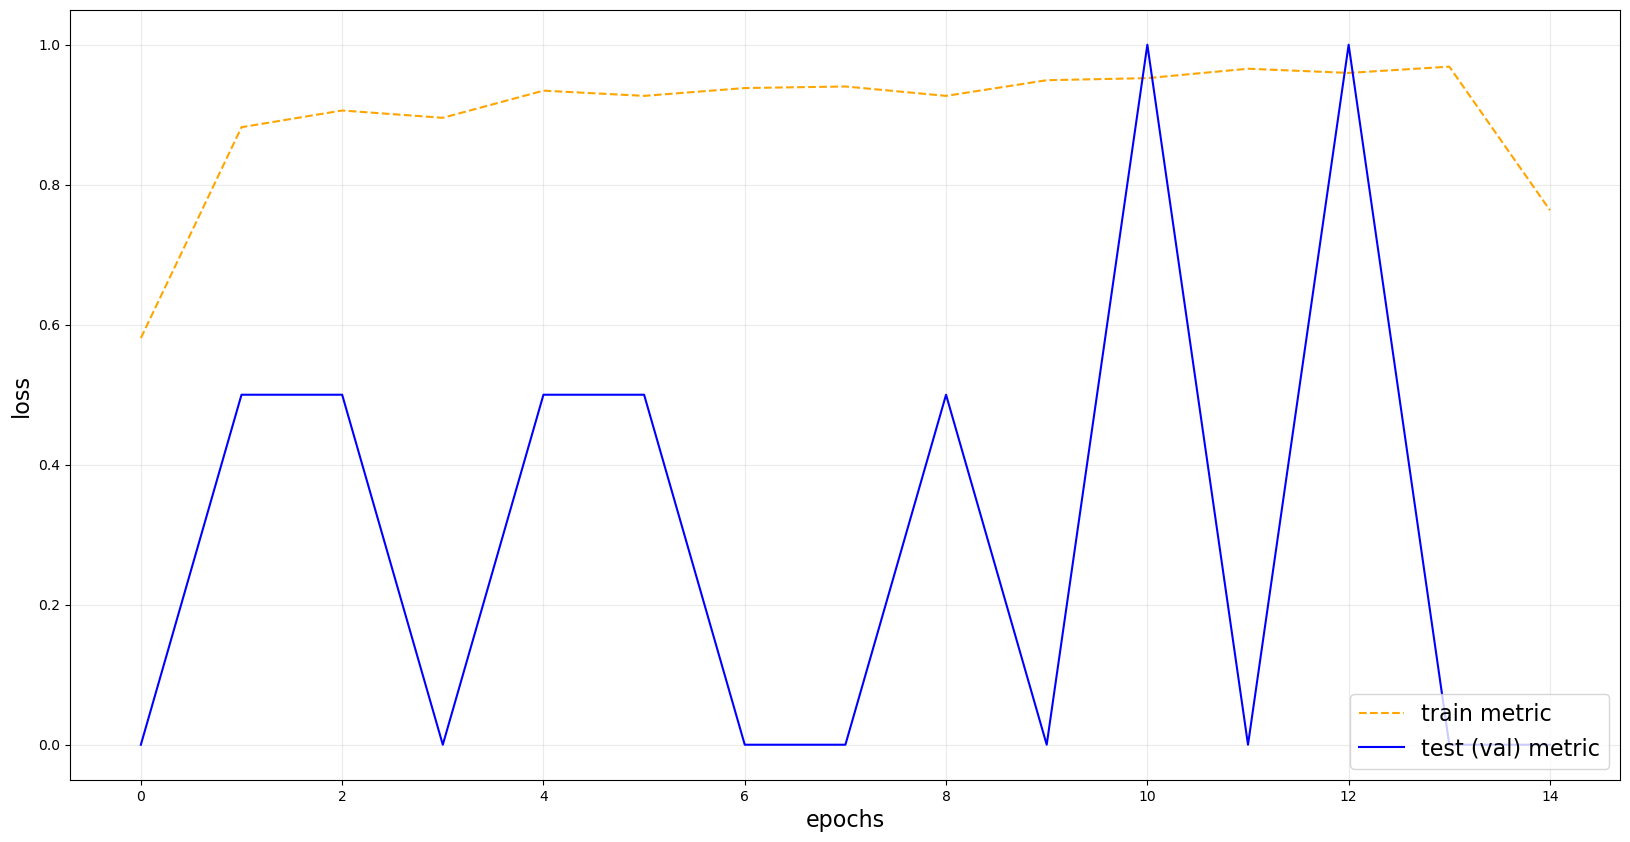

In [9]:
# Recall graph
model.create_graph(15, 1, train_recalls, val_recalls)

As we can see from the graph above, recall increases significantly between the first two epochs, reaching 0.88, and then converging towards 0.95 for most of our later epochs. This result is promising since it means that we are correctly predicting the 'pneumonia' cases 95\% of the time. However, when we evaluate this metric for our validation set, we see hills and valleys as we iterate over the data. Given the nature of the validation data (8 x-rays for each class), we tried not to read much into it since it doesn't have a significant size in order to be relevant for our hyper parameter tuning analysis.

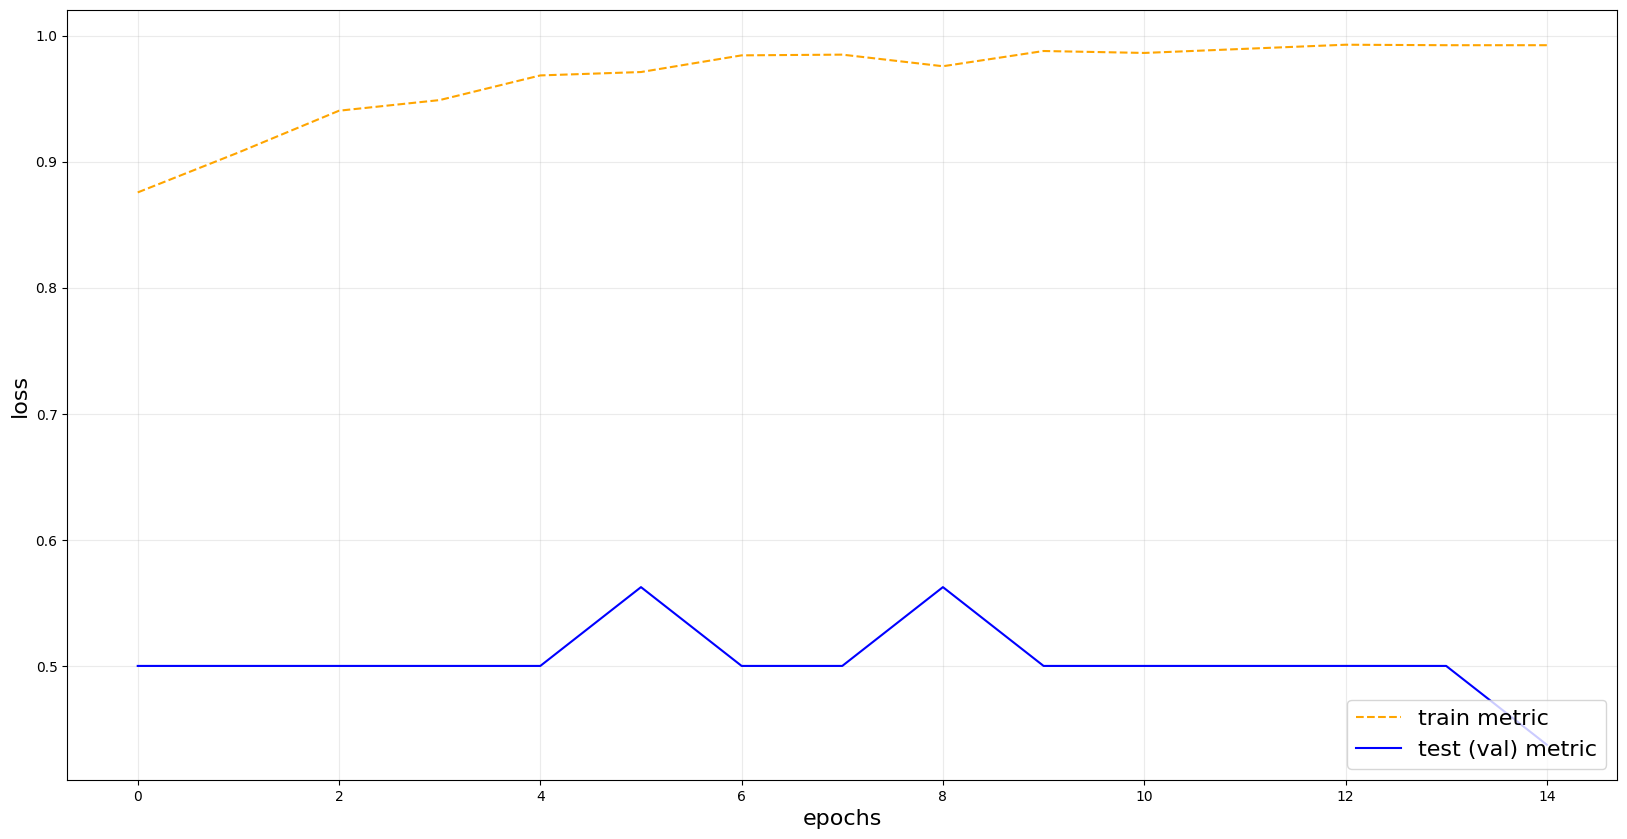

In [11]:
# Accuracy evolution
model.create_graph(15, 1, train_accuracies, val_accuracies)

Finally, we plot the evolution of our accuracy metric, which for our training data is around 98%. Just as it was for recall, our accuracy metric for the validation dataset is not very imformative, since it oscilates around 50% as we go throught the data multiple times.

## Final thoughts

In this checkpoint we've defined relevant accuracy metrics for analyzing the performance of our proposed neural network. Even though we've built a functioning NN, there is still more work to do regarding filter type, number of filters, and hyper parameter tunining. Regarding the former, so far we've used the CenterCrop, Resize, and GrayScale transformations, but currently we're experimenting with filters that focus on edge detection. Given that pneumonia blurs our x-ray image, effectively and efficiently identifying its spread in the torax (and therefore being able to spot its edges) could be a relevant and useful tool to achieve our goal of increasing the True Negative predictions.

Our next steps will focus on trying different model alternatives, each with its own performance-accuracy tradeoffs, and proposing the one that we believe better aligns with our objective as well as with efficiency concerns.